## Imports

In [1]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

from fastprogress.fastprogress import master_bar, progress_bar

from jupyterthemes import jtplot

from torch.utils.data import DataLoader, Subset
from torchsummary import summary
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, Normalize, ToTensor
from torchvision.utils import make_grid

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

jtplot.style(context="talk")

## Dataset Utility

In [2]:
def get_cifar10_data_loaders(path, batch_size, valid_batch_size=0):
    # TINT TODO: Change this to utilize some of the training progress we made in bw_colorizer

    # Data specific transforms
    data_std = (0.2470, 0.2435, 0.2616)
    data_mean = (0.4914, 0.4822, 0.4465)
    xforms = Compose([ToTensor(), Normalize(data_mean, data_std)])

    # Training dataset and loader
    train_dataset = CIFAR10(root=path, train=True, download=True, transform=xforms)

    # Set the batch size to N if batch_size is 0
    tbs = len(train_dataset) if batch_size == 0 else batch_size
    train_loader = DataLoader(train_dataset, batch_size=tbs, shuffle=True)

    valid_dataset = CIFAR10(root=path, train=False, download=True, transform=xforms)

    # Set the batch size to N if batch_size is 0
    vbs = len(valid_dataset) if valid_batch_size == 0 else valid_batch_size
    valid_loader = DataLoader(valid_dataset, batch_size=vbs, shuffle=True)

    return train_loader, valid_loader

## Training Utility

In [3]:
def train_one_epoch(mb, loader, device, model, criterion, optimizer):

    model.train()

    losses = []

    num_batches = len(loader)
    dataiterator = iter(loader)

    for batch in progress_bar(range(num_batches), parent=mb):

        mb.child.comment = "Training"

        # Grab the batch of data and send it to the correct device
        X, Y = next(dataiterator)
        X, Y = X.to(device), Y.to(device)

        # Compute the output
        output = model(X)

        # Compute loss
        loss = criterion(output, Y)
        losses.append(loss.item())

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return losses

## Validation Utility

In [4]:
def validate(mb, loader, device, model, criterion):

    model.eval()

    losses = []
    num_correct = 0

    num_classes = len(loader.dataset.classes)
    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    N = len(loader.dataset)
    num_batches = len(loader)
    dataiterator = iter(loader)

    with torch.no_grad():

        batches = range(num_batches)
        batches = progress_bar(batches, parent=mb) if mb else batches
        for batch in batches:

            if mb:
                mb.child.comment = f"Validation"

            # Grab the batch of data and send it to the correct device
            X, Y = next(dataiterator)
            X, Y = X.to(device), Y.to(device)

            output = model(X)

            loss = criterion(output, Y)
            losses.append(loss.item())

            # Convert network output into predictions (one-hot -> number)
            predictions = output.argmax(dim=1)

            # Sum up total number that were correct
            comparisons = predictions == Y
            num_correct += comparisons.type(torch.float).sum().item()

            # Sum up number of correct per class
            for result, clss in zip(comparisons, Y):
                class_correct[clss] += result.item()
                class_total[clss] += 1

    accuracy = 100 * (num_correct / N)
    accuracies = {
        clss: 100 * class_correct[clss] / class_total[clss]
        for clss in range(num_classes)
    }

    return losses, accuracy, accuracies

## Loss Plotting Utility

In [5]:
def update_plots(mb, train_losses, valid_losses, epoch, num_epochs):

    # Update plot data
    max_loss = max(max(train_losses), max(valid_losses))
    min_loss = min(min(train_losses), min(valid_losses))

    x_margin = 0.2
    x_bounds = [0 - x_margin, num_epochs + x_margin]

    y_margin = 0.1
    y_bounds = [min_loss - y_margin, max_loss + y_margin]

    train_xaxis = torch.linspace(0, epoch + 1, len(train_losses))
    valid_xaxis = torch.linspace(0, epoch + 1, len(valid_losses))
    graph_data = [[train_xaxis, train_losses], [valid_xaxis, valid_losses]]

    mb.update_graph(graph_data, x_bounds, y_bounds)

## Data Loading

In [6]:
# TODO: tune the training batch size
train_batch_size = 128

# Let's use some shared space for the data (so that we don't have copies
# sitting around everywhere)
data_path = "~/data"

# Use the GPUs if they are available
# TODO: if you run into GPU memory errors you should set device to "cpu" and restart the notebook
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using '{device}' device.")

valid_batch_size = 5000
train_loader, valid_loader = get_cifar10_data_loaders(
    data_path, train_batch_size, valid_batch_size
)

# Input and output sizes depend on data
num_features = torch.Size(train_loader.dataset.data.shape[1:]).numel()
class_names = train_loader.dataset.classes
num_classes = len(class_names)

print(class_names)

Using 'cuda' device.


100%|██████████| 170M/170M [00:05<00:00, 31.1MB/s] 


Extracting /home/jmpb2020/data/cifar-10-python.tar.gz to /home/jmpb2020/data
Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


      frog      truck      truck       deer automobile automobile       bird      horse
      ship        cat       deer      horse      horse       bird      truck      truck
     truck        cat       bird       frog       deer        cat       frog       frog
      bird       frog        cat        dog       deer   airplane   airplane      truck
automobile        cat       deer   airplane        cat      horse        cat        cat
       dog       bird       bird      horse automobile automobile automobile       bird
      bird   airplane      truck        dog      horse      truck       bird       bird
       dog       bird       deer        cat automobile automobile       ship       bird


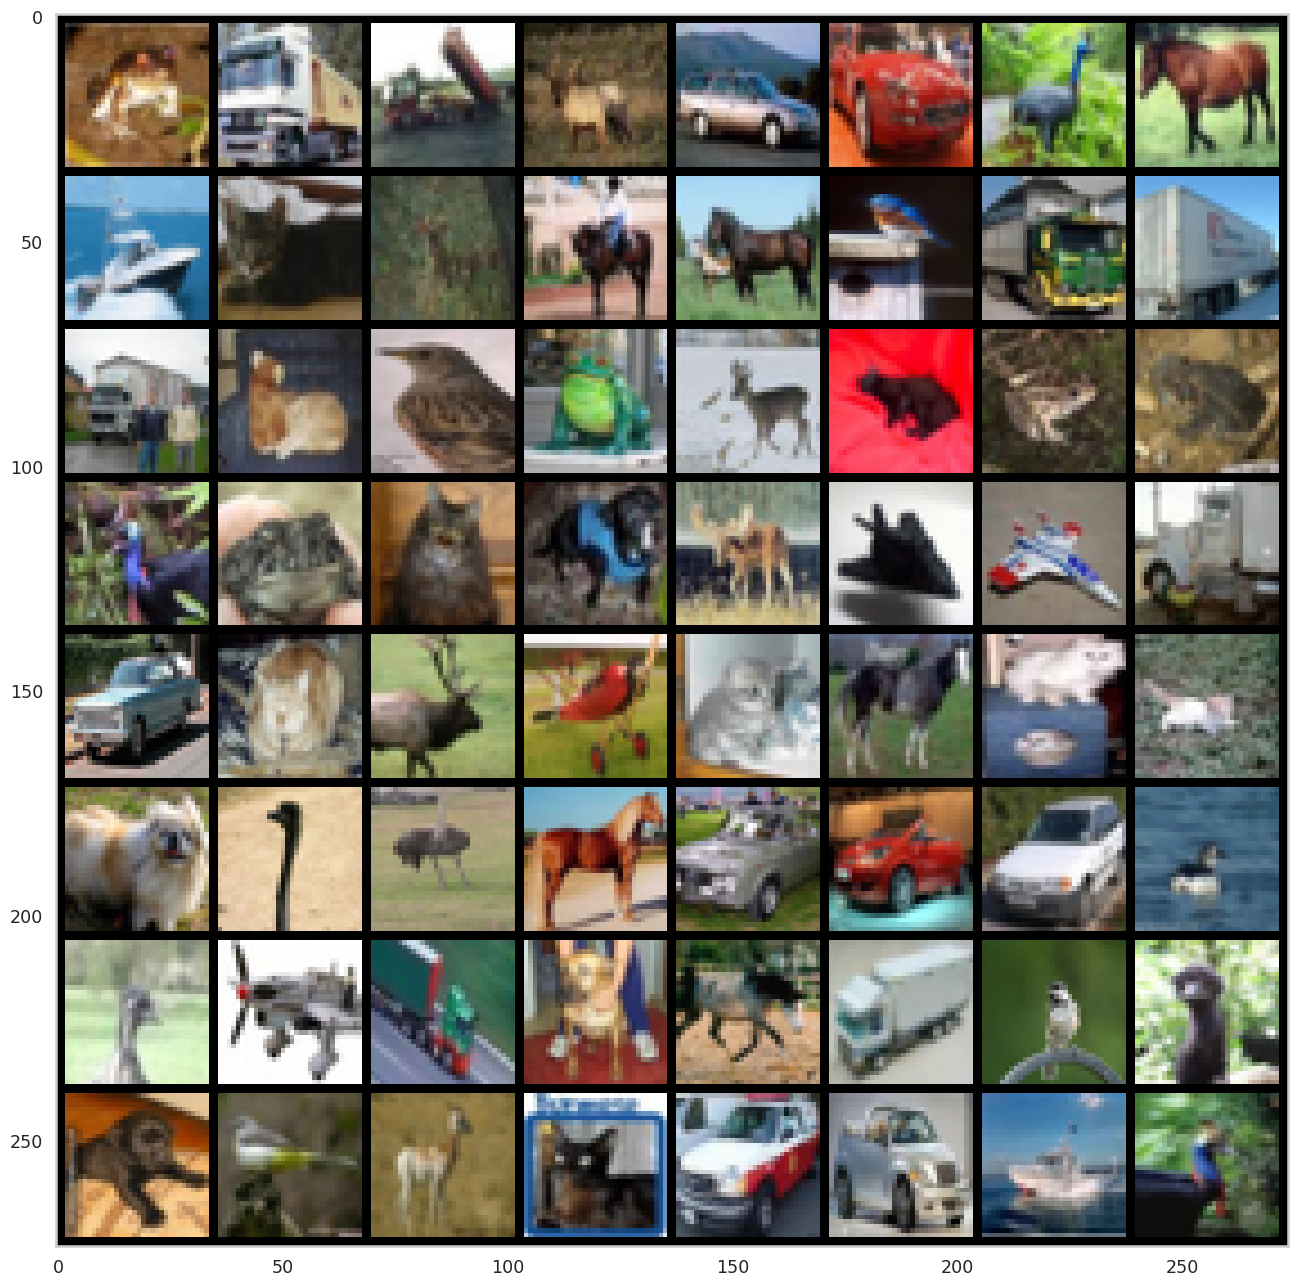

In [7]:
# Grab a bunch of images and change the range to [0, 1]
nprint = 64
images = torch.tensor(train_loader.dataset.data[:nprint] / 255)
targets = train_loader.dataset.targets[:nprint]
labels = [f"{class_names[target]:>10}" for target in targets]

# Create a grid of the images (make_grid expects (BxCxHxW))
image_grid = make_grid(images.permute(0, 3, 1, 2))

_, ax = plt.subplots(figsize=(16, 16))
ax.imshow(image_grid.permute(1, 2, 0))
ax.grid(None)

images_per_row = int(nprint ** 0.5)
for row in range(images_per_row):
    start_index = row * images_per_row
    print(" ".join(labels[start_index : start_index + images_per_row]))

## Model Creation

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()

        # The first "layer" just rearranges an image into a column vector
        first_layer = nn.Flatten()

        # The hidden layers include:
        # 1. a linear component (computing Z) and
        # 2. a non-linear comonent (computing A)
        # TODO: add dropout and/or batch normalization
        hidden_layers = [
            nn.Sequential(nn.Linear(nlminus1, nl), nn.ReLU())
            for nl, nlminus1 in zip(layer_sizes[1:-1], layer_sizes)
        ]

        # The output layer must be Linear without an activation. See:
        #   https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
        output_layer = nn.Linear(layer_sizes[-2], layer_sizes[-1])

        # Group all layers into the sequential container
        all_layers = [first_layer, *hidden_layers, output_layer]
        self.layers = nn.Sequential(*all_layers)

    def forward(self, X):
        return self.layers(X)

In [34]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # TODO: create layers here

        # Early CNNs had the following structure:
        #    X -> [[Conv2d -> ReLU] x N -> MaxPool2d] x M
        #      -> [Linear -> ReLU] x K -> Linear
        #   Where
        #     0 ≤ N ≤ 3
        #     0 ≤ M ≤ 3
        #     0 ≤ K < 3
        #
        # The "[[Conv2d -> ReLU] x N -> MaxPool2d] x M" part extracts
        # useful features, and the "[Linear -> ReLU] x K -> Linear" part
        # performs the classification.
        self.conv_layers = nn.Sequential(
            # Conv layer 1: (3 input channels, 32 output channels)
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # downsample by 2

            # Conv layer 2: (32 input channels, 64 output channels)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # downsample again
        )

        # After two max-pool layers on 32x32 input → 8x8 feature maps
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  # flatten the output from conv layers
            nn.Linear(64 * 8 * 8, 128),  # fully connected layer
            nn.ReLU(),
            nn.Linear(128, 10)  # 10 output classes for CIFAR-10
        )

    def forward(self, X):

        # TODO: implement forward pass here
        X = self.conv_layers(X)
        X = self.fc_layers(X)
        return X

In [55]:
# TODO: try out different network widths and depths
neurons_per_hidden_layer = [1024, 512, 256]
layer_sizes = [num_features, *neurons_per_hidden_layer, num_classes]
model = NeuralNetwork(layer_sizes).to(device)

# TODO: complete the CNN class in the cell above this one and then uncomment this line
# model = CNN().to(device)

# TODO: use an off-the-shell model from PyTorch
# from torchvision.models import ...
# model = ...

# TINT TODO: make the output have 3 nodes.
from torchvision.models import resnet18
model = resnet18(num_classes=num_classes).to(device)

summary(model)

# TODO: try out different Adam hyperparameters
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,864
|    |    └─BatchNorm2d: 3-5             128
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  36,864
|    |    └─BatchNorm2d: 3-7             128
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  36,864
|    |    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 73,728
|    |    └─BatchNorm2d: 3-12            25

## Training and Analysis

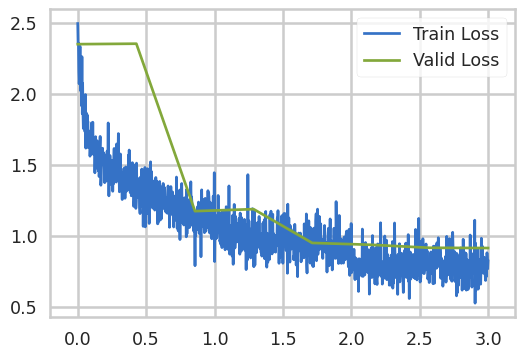

In [56]:
# TODO: tune the number of epochs
num_epochs = 3

train_losses = []
valid_losses = []
accuracies = []

# A master bar for fancy output progress
mb = master_bar(range(num_epochs))
mb.names = ["Train Loss", "Valid Loss"]
mb.main_bar.comment = f"Epochs"

# Loss and accuracy prior to training
vl, accuracy, _ = validate(None, valid_loader, device, model, criterion)
valid_losses.extend(vl)
accuracies.append(accuracy)

for epoch in mb:

    tl = train_one_epoch(mb, train_loader, device, model, criterion, optimizer)
    train_losses.extend(tl)

    vl, accuracy, acc_by_class = validate(mb, valid_loader, device, model, criterion)
    valid_losses.extend(vl)
    accuracies.append(accuracy)

    update_plots(mb, train_losses, valid_losses, epoch, num_epochs)

Accuracy per class
      airplane: 66.4%
    automobile: 89.7%
          bird: 64.1%
           cat: 34.1%
          deer: 68.3%
           dog: 67.2%
          frog: 68.7%
         horse: 66.0%
          ship: 84.4%
         truck: 73.0%


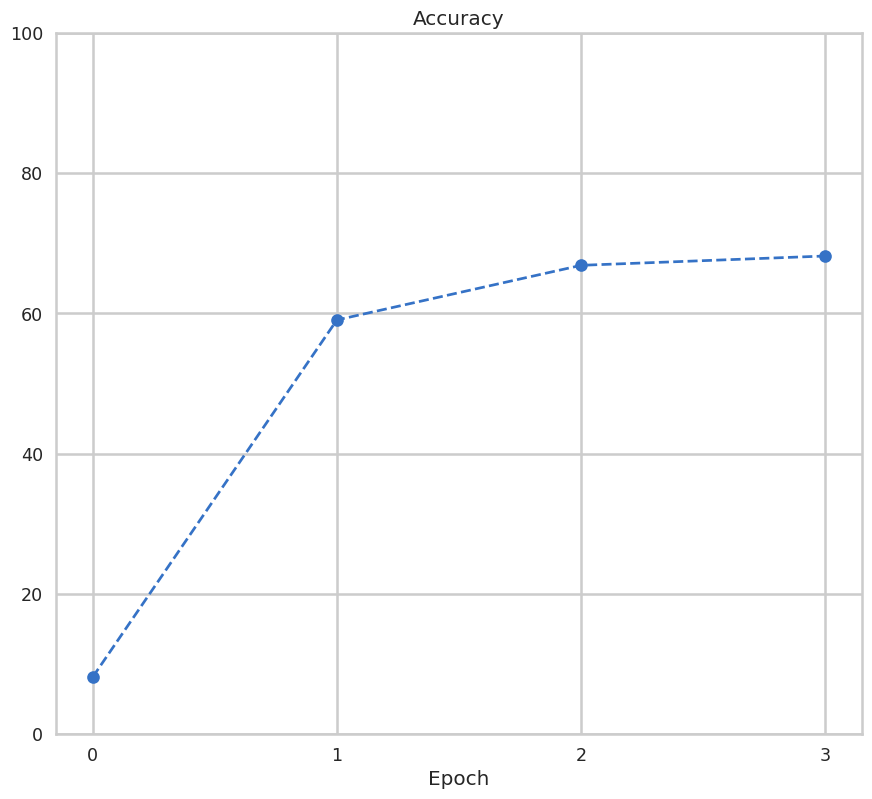

In [57]:
plt.plot(accuracies, '--o')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.xticks(range(num_epochs+1))
plt.ylim([0, 100])

max_name_len = max(len(name) for name in class_names)

print("Accuracy per class")
for clss in acc_by_class:
    class_name = class_names[clss]
    class_accuracy = acc_by_class[clss]
    print(f"  {class_name:>{max_name_len+2}}: {class_accuracy:.1f}%")

In [58]:
y_trues = []
y_preds = []
model.to(device)
for x, y in valid_loader:
    y_trues.append(y.cpu())
    y_preds.append(model(x.to(device)).argmax(dim=1).cpu())

y_true = torch.hstack(y_trues)
y_pred = torch.hstack(y_preds)

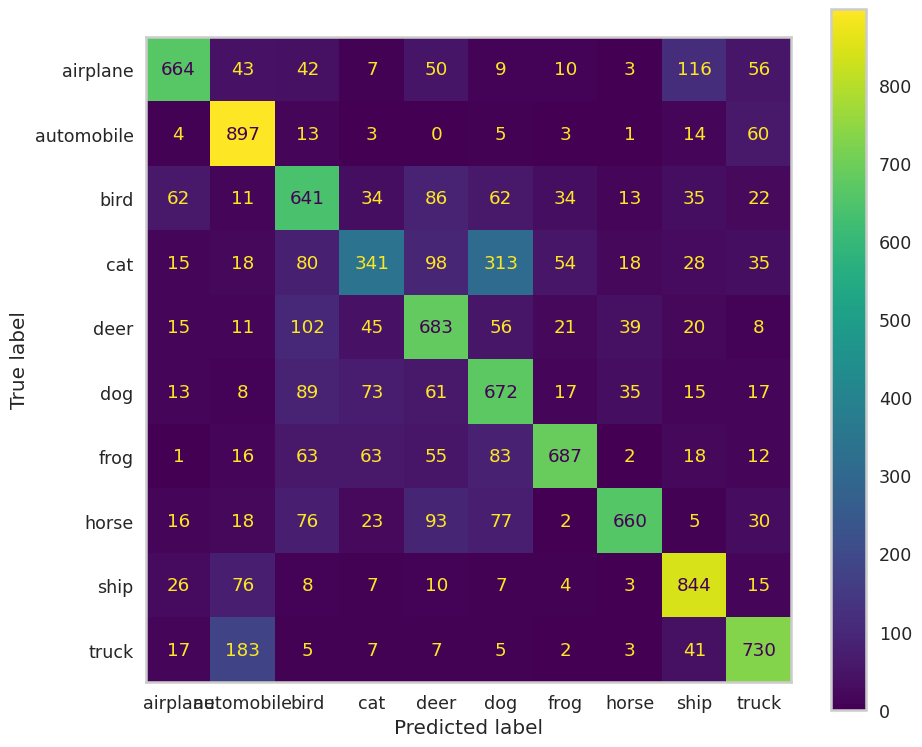

In [59]:
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot();
plt.grid(False)

In [ ]:
# TODO: Take the three outputs and reconstruct an image